In [8]:
# necessary imports
# from google.colab import drive
import os
import glob
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import joblib



In [ ]:
# establish connection to google drive
drive.mount('/content/drive')

NameError: name 'drive' is not defined

In [5]:
import os
import glob
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import joblib

# Enable cuDNN benchmarking if input sizes are constant (improves GPU speed)
torch.backends.cudnn.benchmark = True

#########################################
# 1. DATA LOADING, PROCESSING & FEATURE ENGINEERING
#########################################

def load_stock_data(file_pattern: str) -> pd.DataFrame:
    all_dfs = []
    files = glob.glob(file_pattern)
    for file in tqdm(files, desc="Loading JSON files"):
        if not os.path.basename(file).startswith("AAPL_"):
            continue
        try:
            with open(file, 'r') as f:
                data = json.load(f)
                metadata = data["Meta Data"]
                symbol = metadata["2. Symbol"]
                interval = metadata["4. Interval"]
                if interval != "1min":
                    print(f"Warning: {file} has interval {interval} (expected '1min'). Skipping.")
                    continue
                ts_key = f"Time Series ({interval})"
                ts_data = data.get(ts_key)
                if not ts_data:
                    print(f"Warning: {ts_key} not found in {file}. Skipping.")
                    continue
                df = pd.DataFrame(ts_data).T
                df = df.apply(pd.to_numeric)
                df["symbol"] = symbol
                all_dfs.append(df)
        except Exception as e:
            print(f"Error loading {file}: {str(e)}")
            continue
    if not all_dfs:
        raise ValueError("No valid data found in any files.")
    combined_df = pd.concat(all_dfs)
    combined_df.index = pd.to_datetime(combined_df.index)
    combined_df = combined_df.sort_index()
    combined_df.columns = [col.split(". ")[-1] for col in combined_df.columns]
    return combined_df

raw_df = load_stock_data("drive/MyDrive/software-engineering/alphavantage/data/AAPL_*.json")

def process_stock_data(df: pd.DataFrame, fill_method: str = 'ffill',
                       filter_market_hours: bool = True, timezone: str = 'US/Eastern') -> pd.DataFrame:
    if df.index.tz is None:
        df.index = df.index.tz_localize(timezone)
    processed_dfs = []
    for symbol, group in df.groupby('symbol'):
        group = group[~group.index.duplicated(keep='last')]
        full_range = pd.date_range(start=group.index.min(), end=group.index.max(), freq='1T', tz=timezone)
        group = group.reindex(full_range)
        group['symbol'] = symbol
        if fill_method == 'ffill':
            group = group.ffill()
        elif fill_method == 'bfill':
            group = group.bfill()
        elif fill_method == 'interpolate':
            group = group.interpolate()
        else:
            raise ValueError(f"Invalid fill_method: {fill_method}.")
        if filter_market_hours:
            group = group.between_time('09:30', '16:00')
        processed_dfs.append(group)
    processed_df = pd.concat(processed_dfs)
    return processed_df

def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    if df.index.tz is None:
        df.index = df.index.tz_localize('US/Eastern')
    # Intraday cyclical features
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['sin_minute'] = np.sin(2 * np.pi * df['minute'] / 60)
    df['cos_minute'] = np.cos(2 * np.pi * df['minute'] / 60)
    # Daily features
    df['day_of_week'] = df.index.dayofweek
    df['day_of_month'] = df.index.day
    df['month'] = df.index.month
    df['day_of_year'] = df.index.dayofyear
    df['year'] = df.index.year
    return df

processed_df = process_stock_data(raw_df, fill_method='ffill', filter_market_hours=True)
processed_df = add_time_features(processed_df)
processed_df.to_csv("processed_stock_data.csv", index_label='timestamp')
print("Data processed. Time range:", processed_df.index.min(), "to", processed_df.index.max())

#########################################
# 2. NORMALIZATION
#########################################

# Feature order: Price fields (open, high, low, close, volume), intraday cyclical, then daily features.
features_to_normalize = ['open', 'high', 'low', 'close', 'volume',
                           'sin_hour', 'cos_hour', 'sin_minute', 'cos_minute',
                           'day_of_week', 'day_of_month', 'month', 'day_of_year', 'year']

scaler = StandardScaler()
normalized_values = scaler.fit_transform(processed_df[features_to_normalize])
normalized_df = pd.DataFrame(normalized_values, columns=features_to_normalize, index=processed_df.index)
normalized_df['symbol'] = processed_df['symbol']
print("Normalized DataFrame head:")
print(normalized_df.head())
joblib.dump(scaler, "scaler_minute.pkl")

#########################################
# 3. SEQUENCE CREATION: DIRECT MULTI-STEP FORECASTING WITH INCREMENTAL TARGETS
#########################################

def create_sequences_multi(data: np.ndarray, window_size: int, forecast_horizon: int):
    """
    Create sequences where the input is the past 'window_size' minutes and the target is
    the next 'forecast_horizon' incremental differences for the "close" price.
    For each sample:
      baseline = close at the last minute of the input window,
      target[0] = close at t+1 - baseline,
      target[t] = close at t+t_offset - close at t+t_offset-1 for t>=1.
    This yields a target vector of length forecast_horizon.
    """
    X, y = [], []
    for i in range(len(data) - window_size - forecast_horizon + 1):
        seq_input = data[i:i+window_size]
        seq_target = data[i+window_size:i+window_size+forecast_horizon, 3]  # index 3 is "close"
        baseline = seq_input[-1, 3]
        # Compute incremental differences:
        # The first difference is relative to baseline.
        first_diff = seq_target[0] - baseline
        if forecast_horizon > 1:
            subsequent_diff = np.diff(np.concatenate([[seq_target[0]], seq_target]))
            # Now subsequent_diff[0] equals first_diff; subsequent_diff[t] = seq_target[t] - seq_target[t-1]
            incremental_diff = subsequent_diff  # shape: (forecast_horizon,)
        else:
            incremental_diff = np.array([first_diff])
        X.append(seq_input)
        y.append(incremental_diff)
    return np.array(X), np.array(y)

WINDOW_SIZE = 60       # Past 60 minutes as input
forecast_horizon = 60  # Predict the next 60 minutes at once

data_array = normalized_df[features_to_normalize].values
X_multi, y_multi = create_sequences_multi(data_array, WINDOW_SIZE, forecast_horizon)
print("X_multi shape:", X_multi.shape, "y_multi shape:", y_multi.shape)

#########################################
# 4. PYTORCH DATASET & MULTI-STEP LSTM MODEL WITH RESIDUAL CONNECTION
#########################################

class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Split data into training and validation sets (maintaining time order)
X_train, X_val, y_train, y_val = train_test_split(X_multi, y_multi, test_size=0.2, shuffle=False)
train_dataset = StockDataset(X_train, y_train)
val_dataset   = StockDataset(X_val, y_val)

# DataLoader optimizations: use multiple workers and pin_memory.
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=4)

# Define a multi-step LSTM model with residual connection (predicting incremental differences)
class MultiStepLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, forecast_horizon, dropout=0.2):
        super(MultiStepLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.forecast_horizon = forecast_horizon
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, forecast_horizon)
    def forward(self, x):
        # x shape: (batch, WINDOW_SIZE, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
        out, _ = self.lstm(x, (h0, c0))
        incremental = self.fc(out[:, -1, :])  # predicted incremental differences, shape: (batch, forecast_horizon)
        return incremental

input_size = len(features_to_normalize)
hidden_size = 256     # Increased hidden size for extra capacity
num_layers = 2
model = MultiStepLSTMModel(input_size, hidden_size, num_layers, forecast_horizon, dropout=0.2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#########################################
# 5. TRAINING THE MODEL WITH AMP, LR SCHEDULER & WEIGHT DECAY
#########################################

EPOCHS = 100
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

# Use PyTorch AMP (Automatic Mixed Precision) for faster training on GPU.
scaler_amp = torch.cuda.amp.GradScaler()

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            with torch.cuda.amp.autocast():
                output = model(batch_x)
                loss = criterion(output, batch_y)
            total_loss += loss.item() * batch_x.size(0)
    return total_loss / len(loader.dataset)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(batch_x)
            loss = criterion(output, batch_y)
        scaler_amp.scale(loss).backward()
        scaler_amp.step(optimizer)
        scaler_amp.update()
        total_loss += loss.item() * batch_x.size(0)
    avg_train_loss = total_loss / len(train_loader.dataset)
    avg_val_loss = evaluate(model, val_loader, device)
    scheduler.step()
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

torch.save(model.state_dict(), "trained_model_minute_multistep_residual_amp.pth")

#########################################
# 6. FORECASTING (DIRECT MULTI-STEP) ON THE LATEST SEQUENCE
#########################################

# Use the last WINDOW_SIZE rows from normalized data as the input sequence.
last_sequence = data_array[-WINDOW_SIZE:]  # shape: (WINDOW_SIZE, num_features)
initial_sequence = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    # The model predicts incremental differences for each minute.
    predicted_increments = model(initial_sequence).cpu().numpy().flatten()  # shape: (forecast_horizon,)

# Reconstruct forecast by computing the cumulative sum of predicted increments.
last_norm_close = last_sequence[-1, 3]
cumulative_increments = np.cumsum(predicted_increments)
forecast_norm = last_norm_close + cumulative_increments

# To inverse-transform, create a placeholder array for each forecast step.
pred_placeholder = np.zeros((len(predicted_increments), len(features_to_normalize)))
pred_placeholder[:, 3] = forecast_norm
predicted_prices = scaler.inverse_transform(pred_placeholder)[:, 3]
print("Predicted Prices (Original Scale):", predicted_prices)

#########################################
# 7. PLOTTING THE PREDICTIONS
#########################################

historical_data = processed_df[['close']].iloc[-200:]
last_time = historical_data.index[-1]
forecast_times = pd.date_range(last_time + pd.Timedelta(minutes=1), periods=forecast_horizon, freq='T')

plt.figure(figsize=(12, 6))
plt.plot(historical_data.index, historical_data['close'], label="Historical Close Price", lw=2)
plt.plot(forecast_times, predicted_prices, label="Forecasted Close Price", lw=2, marker='o')
plt.axvline(x=historical_data.index[-1], color="gray", linestyle="--", lw=1, label="Forecast Start")
plt.title("AAPL Close Price Forecast (Next 60 Minutes)")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Loading JSON files: 0it [00:00, ?it/s]


ValueError: No valid data found in any files.

Loading JSON files: 100%|██████████| 12/12 [00:05<00:00,  2.12it/s]
<ipython-input-4-938f8295d105>:66: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_range = pd.date_range(start=group.index.min(), end=group.index.max(), freq='1T', tz=timezone)


Data processed. Time range: 2024-01-02 09:30:00-05:00 to 2024-12-31 16:00:00-05:00
Normalized DataFrame head:
                               open      high       low     close    volume  \
2024-01-02 09:30:00-05:00 -0.803345 -0.770856 -0.831948 -0.777085  2.639778   
2024-01-02 09:31:00-05:00 -0.776965 -0.768140 -0.782270 -0.779607  0.589408   
2024-01-02 09:32:00-05:00 -0.779292 -0.755731 -0.778390 -0.758914  0.486502   
2024-01-02 09:33:00-05:00 -0.758537 -0.760770 -0.775285 -0.764282  0.317137   
2024-01-02 09:34:00-05:00 -0.764552 -0.766979 -0.780718 -0.780964  0.258956   

                           sin_hour  cos_hour  sin_minute  cos_minute  \
2024-01-02 09:30:00-05:00  1.661895  1.590095    0.069269   -1.412409   
2024-01-02 09:31:00-05:00  1.661895  1.590095   -0.079101   -1.404671   
2024-01-02 09:32:00-05:00  1.661895  1.590095   -0.225845   -1.381544   
2024-01-02 09:33:00-05:00  1.661895  1.590095   -0.369356   -1.343280   
2024-01-02 09:34:00-05:00  1.661895  1.590095   -0

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/100, Loss: 0.008634
Epoch 2/100, Loss: 0.000898
Epoch 3/100, Loss: 0.000875
Epoch 4/100, Loss: 0.000858
Epoch 5/100, Loss: 0.000839
Epoch 6/100, Loss: 0.000803
Epoch 7/100, Loss: 0.000778
Epoch 8/100, Loss: 0.000752
Epoch 9/100, Loss: 0.000728
Epoch 10/100, Loss: 0.000683
Epoch 11/100, Loss: 0.000648
Epoch 12/100, Loss: 0.000616
Epoch 13/100, Loss: 0.000573
Epoch 14/100, Loss: 0.000517
Epoch 15/100, Loss: 0.000476
Epoch 16/100, Loss: 0.000487
Epoch 17/100, Loss: 0.000442
Epoch 18/100, Loss: 0.000427
Epoch 19/100, Loss: 0.000366
Epoch 20/100, Loss: 0.000348
Epoch 21/100, Loss: 0.000336
Epoch 22/100, Loss: 0.000327
Epoch 23/100, Loss: 0.000298
Epoch 24/100, Loss: 0.000274
Epoch 25/100, Loss: 0.000248
Epoch 26/100, Loss: 0.000274
Epoch 27/100, Loss: 0.000223
Epoch 28/100, Loss: 0.000211
Epoch 29/100, Loss: 0.000203
Epoch 30/100, Loss: 0.000202
Epoch 31/100, Loss: 0.000198
Epoch 32/100, Loss: 0.000171
Epoch 33/100, Loss: 0.000207
Epoch 34/100, Loss: 0.000176
Epoch 35/100, Loss: 0.0

<ipython-input-4-938f8295d105>:251: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  forecast_times = pd.date_range(last_time + pd.Timedelta(minutes=1), periods=forecast_horizon, freq='T')


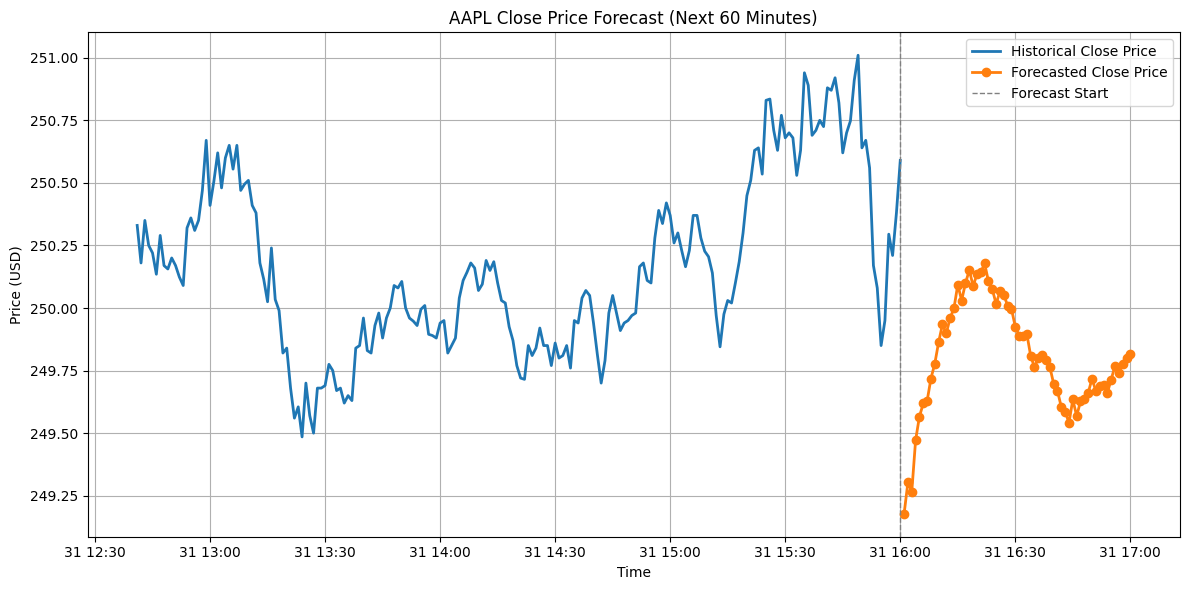

In [4]:
import os
import glob
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import joblib

#########################################
# 1. DATA LOADING, PROCESSING & FEATURE ENGINEERING
#########################################

def load_stock_data(file_pattern: str) -> pd.DataFrame:
    all_dfs = []
    files = glob.glob(file_pattern)
    for file in tqdm(files, desc="Loading JSON files"):
        if not os.path.basename(file).startswith("AAPL_"):
            continue
        try:
            with open(file, 'r') as f:
                data = json.load(f)
                metadata = data["Meta Data"]
                symbol = metadata["2. Symbol"]
                interval = metadata["4. Interval"]
                if interval != "1min":
                    print(f"Warning: {file} has interval {interval} (expected '1min'). Skipping.")
                    continue
                ts_key = f"Time Series ({interval})"
                ts_data = data.get(ts_key)
                if not ts_data:
                    print(f"Warning: {ts_key} not found in {file}. Skipping.")
                    continue
                df = pd.DataFrame(ts_data).T
                df = df.apply(pd.to_numeric)
                df["symbol"] = symbol
                all_dfs.append(df)
        except Exception as e:
            print(f"Error loading {file}: {str(e)}")
            continue
    if not all_dfs:
        raise ValueError("No valid data found in any files.")
    combined_df = pd.concat(all_dfs)
    combined_df.index = pd.to_datetime(combined_df.index)
    combined_df = combined_df.sort_index()
    combined_df.columns = [col.split(". ")[-1] for col in combined_df.columns]
    return combined_df

# Load minute-level data (e.g. files like "AAPL_2024-01.json")
raw_df = load_stock_data("drive/MyDrive/software-engineering/alphavantage/data/AAPL_*.json")

def process_stock_data(df: pd.DataFrame, fill_method: str = 'ffill',
                       filter_market_hours: bool = True, timezone: str = 'US/Eastern') -> pd.DataFrame:
    if df.index.tz is None:
        df.index = df.index.tz_localize(timezone)
    processed_dfs = []
    for symbol, group in df.groupby('symbol'):
        group = group[~group.index.duplicated(keep='last')]
        full_range = pd.date_range(start=group.index.min(), end=group.index.max(), freq='1T', tz=timezone)
        group = group.reindex(full_range)
        group['symbol'] = symbol
        if fill_method == 'ffill':
            group = group.ffill()
        elif fill_method == 'bfill':
            group = group.bfill()
        elif fill_method == 'interpolate':
            group = group.interpolate()
        else:
            raise ValueError(f"Invalid fill_method: {fill_method}.")
        if filter_market_hours:
            group = group.between_time('09:30', '16:00')
        processed_dfs.append(group)
    processed_df = pd.concat(processed_dfs)
    return processed_df

def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    if df.index.tz is None:
        df.index = df.index.tz_localize('US/Eastern')
    # Intraday cyclical features
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['sin_minute'] = np.sin(2 * np.pi * df['minute'] / 60)
    df['cos_minute'] = np.cos(2 * np.pi * df['minute'] / 60)
    # Daily features
    df['day_of_week'] = df.index.dayofweek
    df['day_of_month'] = df.index.day
    df['month'] = df.index.month
    df['day_of_year'] = df.index.dayofyear
    df['year'] = df.index.year
    return df

processed_df = process_stock_data(raw_df, fill_method='ffill', filter_market_hours=True)
processed_df = add_time_features(processed_df)

# Optionally, save and verify processed data
processed_df.to_csv("processed_stock_data.csv", index_label='timestamp')
print("Data processed. Time range:", processed_df.index.min(), "to", processed_df.index.max())

#########################################
# 2. NORMALIZATION
#########################################

# Define the features in a specific order:
# Price fields (open, high, low, close, volume), then intraday cyclical, then daily.
features_to_normalize = ['open', 'high', 'low', 'close', 'volume',
                           'sin_hour', 'cos_hour', 'sin_minute', 'cos_minute',
                           'day_of_week', 'day_of_month', 'month', 'day_of_year', 'year']

scaler = StandardScaler()
normalized_values = scaler.fit_transform(processed_df[features_to_normalize])
normalized_df = pd.DataFrame(normalized_values, columns=features_to_normalize, index=processed_df.index)
normalized_df['symbol'] = processed_df['symbol']
print("Normalized DataFrame head:")
print(normalized_df.head())
joblib.dump(scaler, "scaler_minute.pkl")

#########################################
# 3. SEQUENCE CREATION: DIRECT MULTI-STEP FORECASTING
#########################################

def create_sequences_multi(data: np.ndarray, window_size: int, forecast_horizon: int):
    """
    Create sequences where the input is the past 'window_size' minutes
    and the target is a vector of the next 'forecast_horizon' "close" values.
    data: numpy array of shape (num_timesteps, num_features)
    Returns:
      X: shape (num_samples, window_size, num_features)
      y: shape (num_samples, forecast_horizon)
    """
    X, y = [], []
    # Note: feature index 3 corresponds to "close"
    for i in range(len(data) - window_size - forecast_horizon + 1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size:i+window_size+forecast_horizon, 3])
    return np.array(X), np.array(y)

WINDOW_SIZE = 60       # past 60 minutes as input
forecast_horizon = 60  # predict the next 60 minutes directly

data_array = normalized_df[features_to_normalize].values
X_multi, y_multi = create_sequences_multi(data_array, WINDOW_SIZE, forecast_horizon)
print("X_multi shape:", X_multi.shape, "y_multi shape:", y_multi.shape)

#########################################
# 4. PYTORCH DATASET & MULTI-STEP LSTM MODEL
#########################################

class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class MultiStepLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, forecast_horizon, dropout=0.2):
        super(MultiStepLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.forecast_horizon = forecast_horizon
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        # The final linear layer outputs a vector of length forecast_horizon
        self.fc = nn.Linear(hidden_size, forecast_horizon)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        # Use the last time step's output
        out = self.fc(out[:, -1, :])
        return out  # shape: (batch_size, forecast_horizon)

input_size = len(features_to_normalize)
hidden_size = 128
num_layers = 1
output_size = forecast_horizon  # not used explicitly; fc outputs forecast_horizon
model = MultiStepLSTMModel(input_size, hidden_size, num_layers, forecast_horizon, dropout=0.2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#########################################
# 5. TRAINING THE MODEL
#########################################

BATCH_SIZE = 64
EPOCHS = 100

dataset = StockDataset(X_multi, y_multi)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)  # (batch, WINDOW_SIZE, input_size)
        batch_y = batch_y.to(device)  # (batch, forecast_horizon)
        optimizer.zero_grad()
        output = model(batch_x)       # (batch, forecast_horizon)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_x.size(0)
    avg_loss = total_loss / len(dataset)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.6f}")

torch.save(model.state_dict(), "trained_model_minute_multistep.pth")

#########################################
# 6. FORECASTING (DIRECT MULTI-STEP)
#########################################

# Use the last WINDOW_SIZE rows from normalized data as the input sequence
last_sequence = data_array[-WINDOW_SIZE:]  # shape: (WINDOW_SIZE, num_features)
initial_sequence = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    predicted_norm = model(initial_sequence).cpu().numpy().flatten()  # shape: (forecast_horizon,)

# Inverse-transform the predicted normalized "close" values.
# We need to construct a placeholder array for each predicted step with the correct number of features.
pred_placeholder = np.zeros((len(predicted_norm), len(features_to_normalize)))
# Set the "close" column (index 3) to the predicted normalized value.
pred_placeholder[:, 3] = predicted_norm
# Inverse transform using the scaler. Only the "close" column is meaningful.
predicted_prices = scaler.inverse_transform(pred_placeholder)[:, 3]
print("Predicted Prices (Original Scale):", predicted_prices)

#########################################
# 7. PLOTTING THE PREDICTIONS
#########################################

# Plot the last 200 minutes of historical close prices and overlay the forecast.
historical_data = processed_df[['close']].iloc[-200:]
# Create a time range for the forecast (next 60 minutes)
last_time = historical_data.index[-1]
forecast_times = pd.date_range(last_time + pd.Timedelta(minutes=1), periods=forecast_horizon, freq='T')

plt.figure(figsize=(12, 6))
plt.plot(historical_data.index, historical_data['close'], label="Historical Close Price", lw=2)
plt.plot(forecast_times, predicted_prices, label="Forecasted Close Price", lw=2, marker='o')
plt.axvline(x=historical_data.index[-1], color="gray", linestyle="--", lw=1, label="Forecast Start")
plt.title("AAPL Close Price Forecast (Next 60 Minutes)")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Loading JSON files: 100%|██████████| 12/12 [00:06<00:00,  1.99it/s]
<ipython-input-6-8c87a520c11d>:66: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_range = pd.date_range(start=group.index.min(), end=group.index.max(), freq='1T', tz=timezone)


Data processed. Time range: 2024-01-02 09:30:00-05:00 to 2024-12-31 16:00:00-05:00
Normalized DataFrame head:
                               open      high       low     close    volume  \
2024-01-02 09:30:00-05:00 -0.803345 -0.770856 -0.831948 -0.777085  2.639778   
2024-01-02 09:31:00-05:00 -0.776965 -0.768140 -0.782270 -0.779607  0.589408   
2024-01-02 09:32:00-05:00 -0.779292 -0.755731 -0.778390 -0.758914  0.486502   
2024-01-02 09:33:00-05:00 -0.758537 -0.760770 -0.775285 -0.764282  0.317137   
2024-01-02 09:34:00-05:00 -0.764552 -0.766979 -0.780718 -0.780964  0.258956   

                           sin_hour  cos_hour  sin_minute  cos_minute  \
2024-01-02 09:30:00-05:00  1.661895  1.590095    0.069269   -1.412409   
2024-01-02 09:31:00-05:00  1.661895  1.590095   -0.079101   -1.404671   
2024-01-02 09:32:00-05:00  1.661895  1.590095   -0.225845   -1.381544   
2024-01-02 09:33:00-05:00  1.661895  1.590095   -0.369356   -1.343280   
2024-01-02 09:34:00-05:00  1.661895  1.590095   -0

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/100, Loss: 0.000070
Epoch 2/100, Loss: 0.000055
Epoch 3/100, Loss: 0.000054
Epoch 4/100, Loss: 0.000053
Epoch 5/100, Loss: 0.000053
Epoch 6/100, Loss: 0.000053
Epoch 7/100, Loss: 0.000053
Epoch 8/100, Loss: 0.000053
Epoch 9/100, Loss: 0.000053
Epoch 10/100, Loss: 0.000053
Epoch 11/100, Loss: 0.000053
Epoch 12/100, Loss: 0.000053
Epoch 13/100, Loss: 0.000053
Epoch 14/100, Loss: 0.000053
Epoch 15/100, Loss: 0.000053
Epoch 16/100, Loss: 0.000053
Epoch 17/100, Loss: 0.000053
Epoch 18/100, Loss: 0.000053
Epoch 19/100, Loss: 0.000053
Epoch 20/100, Loss: 0.000053
Epoch 21/100, Loss: 0.000053
Epoch 22/100, Loss: 0.000053
Epoch 23/100, Loss: 0.000053
Epoch 24/100, Loss: 0.000053
Epoch 25/100, Loss: 0.000053
Epoch 26/100, Loss: 0.000053
Epoch 27/100, Loss: 0.000053
Epoch 28/100, Loss: 0.000053
Epoch 29/100, Loss: 0.000053
Epoch 30/100, Loss: 0.000053
Epoch 31/100, Loss: 0.000053
Epoch 32/100, Loss: 0.000053
Epoch 33/100, Loss: 0.000053
Epoch 34/100, Loss: 0.000053
Epoch 35/100, Loss: 0.0

<ipython-input-6-8c87a520c11d>:269: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  forecast_times = pd.date_range(last_time + pd.Timedelta(minutes=1), periods=forecast_horizon, freq='T')


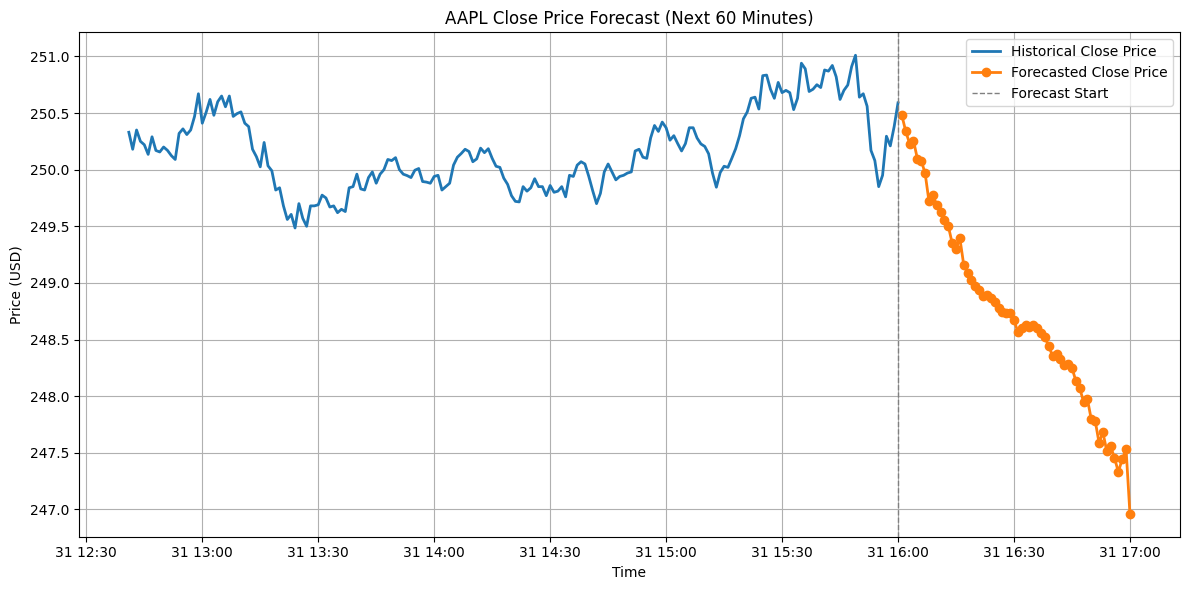

In [6]:
import os
import glob
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import joblib

#########################################
# 1. DATA LOADING, PROCESSING & FEATURE ENGINEERING
#########################################

def load_stock_data(file_pattern: str) -> pd.DataFrame:
    all_dfs = []
    files = glob.glob(file_pattern)
    for file in tqdm(files, desc="Loading JSON files"):
        if not os.path.basename(file).startswith("AAPL_"):
            continue
        try:
            with open(file, 'r') as f:
                data = json.load(f)
                metadata = data["Meta Data"]
                symbol = metadata["2. Symbol"]
                interval = metadata["4. Interval"]
                if interval != "1min":
                    print(f"Warning: {file} has interval {interval} (expected '1min'). Skipping.")
                    continue
                ts_key = f"Time Series ({interval})"
                ts_data = data.get(ts_key)
                if not ts_data:
                    print(f"Warning: {ts_key} not found in {file}. Skipping.")
                    continue
                df = pd.DataFrame(ts_data).T
                df = df.apply(pd.to_numeric)
                df["symbol"] = symbol
                all_dfs.append(df)
        except Exception as e:
            print(f"Error loading {file}: {str(e)}")
            continue
    if not all_dfs:
        raise ValueError("No valid data found in any files.")
    combined_df = pd.concat(all_dfs)
    combined_df.index = pd.to_datetime(combined_df.index)
    combined_df = combined_df.sort_index()
    combined_df.columns = [col.split(". ")[-1] for col in combined_df.columns]
    return combined_df

# Load minute-level data (e.g. files like "AAPL_2024-01.json")
raw_df = load_stock_data("drive/MyDrive/software-engineering/alphavantage/data/AAPL_*.json")

def process_stock_data(df: pd.DataFrame, fill_method: str = 'ffill',
                       filter_market_hours: bool = True, timezone: str = 'US/Eastern') -> pd.DataFrame:
    if df.index.tz is None:
        df.index = df.index.tz_localize(timezone)
    processed_dfs = []
    for symbol, group in df.groupby('symbol'):
        group = group[~group.index.duplicated(keep='last')]
        full_range = pd.date_range(start=group.index.min(), end=group.index.max(), freq='1T', tz=timezone)
        group = group.reindex(full_range)
        group['symbol'] = symbol
        if fill_method == 'ffill':
            group = group.ffill()
        elif fill_method == 'bfill':
            group = group.bfill()
        elif fill_method == 'interpolate':
            group = group.interpolate()
        else:
            raise ValueError(f"Invalid fill_method: {fill_method}.")
        if filter_market_hours:
            group = group.between_time('09:30', '16:00')
        processed_dfs.append(group)
    processed_df = pd.concat(processed_dfs)
    return processed_df

def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    if df.index.tz is None:
        df.index = df.index.tz_localize('US/Eastern')
    # Intraday cyclical features
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['sin_minute'] = np.sin(2 * np.pi * df['minute'] / 60)
    df['cos_minute'] = np.cos(2 * np.pi * df['minute'] / 60)
    # Daily features
    df['day_of_week'] = df.index.dayofweek
    df['day_of_month'] = df.index.day
    df['month'] = df.index.month
    df['day_of_year'] = df.index.dayofyear
    df['year'] = df.index.year
    return df

processed_df = process_stock_data(raw_df, fill_method='ffill', filter_market_hours=True)
processed_df = add_time_features(processed_df)

# Optionally, save and verify processed data
processed_df.to_csv("processed_stock_data.csv", index_label='timestamp')
print("Data processed. Time range:", processed_df.index.min(), "to", processed_df.index.max())

#########################################
# 2. NORMALIZATION
#########################################

# Define the features in a specific order:
# Price fields (open, high, low, close, volume), then intraday cyclical, then daily.
features_to_normalize = ['open', 'high', 'low', 'close', 'volume',
                           'sin_hour', 'cos_hour', 'sin_minute', 'cos_minute',
                           'day_of_week', 'day_of_month', 'month', 'day_of_year', 'year']

scaler = StandardScaler()
normalized_values = scaler.fit_transform(processed_df[features_to_normalize])
normalized_df = pd.DataFrame(normalized_values, columns=features_to_normalize, index=processed_df.index)
normalized_df['symbol'] = processed_df['symbol']
print("Normalized DataFrame head:")
print(normalized_df.head())
joblib.dump(scaler, "scaler_minute.pkl")

#########################################
# 3. SEQUENCE CREATION: DIRECT MULTI-STEP FORECASTING WITH INCREMENTAL TARGETS
#########################################

def create_sequences_multi(data: np.ndarray, window_size: int, forecast_horizon: int):
    """
    Create sequences where the input is the past 'window_size' minutes and the target is
    a vector of the next 'forecast_horizon' incremental differences for the "close" price.

    For each sample:
      Let baseline = close at the last minute of the input window.
      The first target value is:  Δ₀ = close[t₀+1] - baseline.
      For subsequent minutes: Δₜ = close[t₀+t+1] - close[t₀+t], for t>=1.

    Returns:
      X: shape (num_samples, window_size, num_features)
      y: shape (num_samples, forecast_horizon)
    """
    X, y = [], []
    for i in range(len(data) - window_size - forecast_horizon + 1):
        seq_input = data[i:i+window_size]
        # Extract the "close" values from t0 to t0+forecast_horizon (forecast horizon period)
        seq_target = data[i+window_size:i+window_size+forecast_horizon, 3]  # index 3 is "close"
        baseline = seq_input[-1, 3]
        # First incremental difference is relative to the baseline.
        first_diff = seq_target[0] - baseline
        if forecast_horizon > 1:
            # For t>=1, compute the differences between consecutive closes.
            subsequent_diff = np.diff(seq_target)
            incremental_diff = np.concatenate([[first_diff], subsequent_diff])
        else:
            incremental_diff = np.array([first_diff])
        X.append(seq_input)
        y.append(incremental_diff)
    return np.array(X), np.array(y)

WINDOW_SIZE = 60       # past 60 minutes as input
forecast_horizon = 60  # predict the next 60 minutes incrementally

data_array = normalized_df[features_to_normalize].values
X_multi, y_multi = create_sequences_multi(data_array, WINDOW_SIZE, forecast_horizon)
print("X_multi shape:", X_multi.shape, "y_multi shape:", y_multi.shape)

#########################################
# 4. PYTORCH DATASET & MULTI-STEP LSTM MODEL
#########################################

class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class MultiStepLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, forecast_horizon, dropout=0.2):
        super(MultiStepLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.forecast_horizon = forecast_horizon
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        # The final linear layer outputs a vector of length forecast_horizon (predicted incremental differences)
        self.fc = nn.Linear(hidden_size, forecast_horizon)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        incremental = self.fc(out[:, -1, :])
        return incremental  # shape: (batch_size, forecast_horizon)

input_size = len(features_to_normalize)
hidden_size = 128
num_layers = 1
model = MultiStepLSTMModel(input_size, hidden_size, num_layers, forecast_horizon, dropout=0.2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#########################################
# 5. TRAINING THE MODEL
#########################################

BATCH_SIZE = 64
EPOCHS = 100

dataset = StockDataset(X_multi, y_multi)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)  # (batch, WINDOW_SIZE, input_size)
        batch_y = batch_y.to(device)  # (batch, forecast_horizon)
        optimizer.zero_grad()
        output = model(batch_x)       # (batch, forecast_horizon)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_x.size(0)
    avg_loss = total_loss / len(dataset)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.6f}")

torch.save(model.state_dict(), "trained_model_minute_multistep_incremental.pth")

#########################################
# 6. FORECASTING (DIRECT MULTI-STEP) ON THE LATEST SEQUENCE
#########################################

# Use the last WINDOW_SIZE rows from normalized data as the input sequence.
last_sequence = data_array[-WINDOW_SIZE:]  # shape: (WINDOW_SIZE, num_features)
initial_sequence = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    predicted_increments = model(initial_sequence).cpu().numpy().flatten()  # shape: (forecast_horizon,)

# Reconstruct forecast:
# The first forecast value = last_norm_close + predicted_increments[0]
# Subsequent forecast values are computed by cumulatively summing the predicted increments.
last_norm_close = last_sequence[-1, 3]
cumulative_increments = np.cumsum(predicted_increments)
forecast_norm = last_norm_close + cumulative_increments

# Inverse-transform the forecast.
# Create a placeholder array for each forecast step (only the "close" column is used for inversion).
pred_placeholder = np.zeros((len(predicted_increments), len(features_to_normalize)))
pred_placeholder[:, 3] = forecast_norm
predicted_prices = scaler.inverse_transform(pred_placeholder)[:, 3]
print("Predicted Prices (Original Scale):", predicted_prices)

#########################################
# 7. PLOTTING THE PREDICTIONS
#########################################

# Plot the last 200 minutes of historical close prices and overlay the forecast.
historical_data = processed_df[['close']].iloc[-200:]
last_time = historical_data.index[-1]
forecast_times = pd.date_range(last_time + pd.Timedelta(minutes=1), periods=forecast_horizon, freq='T')

plt.figure(figsize=(12, 6))
plt.plot(historical_data.index, historical_data['close'], label="Historical Close Price", lw=2)
plt.plot(forecast_times, predicted_prices, label="Forecasted Close Price", lw=2, marker='o')
plt.axvline(x=historical_data.index[-1], color="gray", linestyle="--", lw=1, label="Forecast Start")
plt.title("AAPL Close Price Forecast (Next 60 Minutes)")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
